# Residency Program Decision Tree Simulation

This decision tree is used to choose students who will be interviewed for matching with the ENT residency program

There are nine features considered:

1. Students who rotated with the program
2. URM (yes/no)
3. Preference given for program (yes/no)
4. USMLE score(s) -- this is STEP1 and STEP2
5. Medical school reputation (US News rank)
6. Research
7. Class rank
8. Letters of recommendation
9. Leadership/other exceptional characteristics

Based on a decision tree, applicants are separated into group A and group B, of which the top group A applicants are interviewed after being sorted based on the quality of their letters, scores, research, and intangibles.

In [1]:
import numpy as np
import pandas as pd
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns
from distributions import *

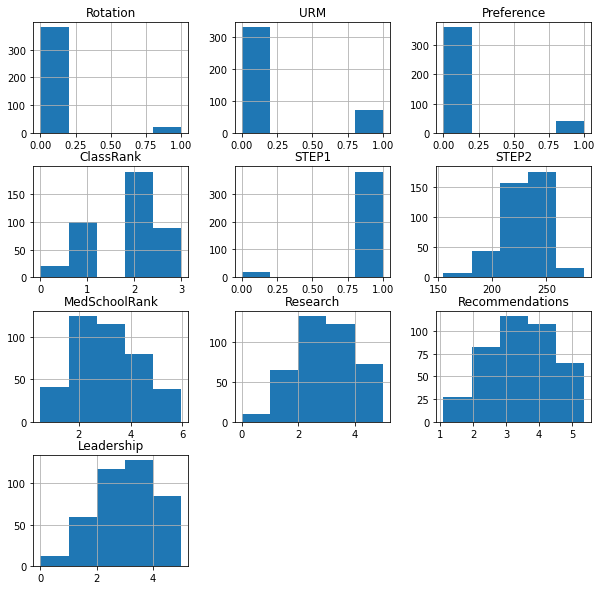

In [2]:
N = 400 # Number of applicants
I = 70 # Number of interviews

applications = pd.DataFrame({'Rotation':sample_rotation(N), 'URM':sample_urm(N),
                             'Preference':sample_preference(N), 'ClassRank':sample_class_rank(N),
                             'STEP1':sample_step_1(N), 'STEP2':sample_step_2(N),
                             'MedSchoolRank':sample_school_rank(N), 'Research':sample_research(N),
                             'Recommendations':sample_recommendation(N), 'Leadership':sample_leadership(N)})

applications.hist(figsize=(10,10), bins=5)
plt.show()

In [3]:
def residency_decision_tree(applications_df, 
                            t_score=None, t_school_rank=None,
                            t_class_rank=None, t_research=None,
                            t_recommendations=None, t_leadership=None,
                            t_exceptional_features=None):
    """
    Sort applications in a DataFrame into Group A and Group B

    Parameters
    -----------
    applications_df: A dataframe of applications with the features described above
    t_*: thresholds for "exceptional" features. Adjust to fit the real-world application process

    Returns
    -----------
    group_a: a sorted list of indices which indicates the applications assigned to Group A
    group_b: a sorted list of indices which indicates the applications assigned to Group B
    
    Rotation             0.000000
    URM                  0.000000
    Preference           0.000000
    ClassRank            2.000000
    STEP1                1.000000
    STEP2              245.000000
    MedSchoolRank        3.998694
    Research             3.000000
    Recommendations      4.155505
    Leadership           3.000000
    """
    
    thresholds = applications_df.quantile(q=0.75, axis=0, interpolation='nearest')
    print(thresholds)
    
    if t_score is None: t_score=245
    if t_school_rank is None: t_school_rank=thresholds.MedSchoolRank
    if t_class_rank is None: t_class_rank=thresholds.ClassRank
    if t_research is None: t_research=thresholds.Research
    if t_recommendations is None: t_recommendations=thresholds.Recommendations
    if t_leadership is None: t_leadership=thresholds.Leadership
    if t_exceptional_features is None: t_exceptional_features=3
    
    def exceptional_features(app):
        """
        Count and return number of exceptional features in an application

        Parameters
        -----------
        app: an application in the form of a row of a dataframe

        Returns
        -----------
        ex_feat: number of exceptional features in the application
        """
        ex_feat = 0
        if app.STEP1==1 and app.STEP2>=t_score: ex_feat+=1
        if app.MedSchoolRank>=t_school_rank: ex_feat+=1
        if app.ClassRank>=t_class_rank: ex_feat+=1
        if app.Research>=t_research: ex_feat+=1
        if app.Recommendations>=t_recommendations: ex_feat+=1
        if app.Leadership>=t_leadership: ex_feat+=1
        return ex_feat
        
    applications = applications_df.copy()
    applications['ExceptionalFeatures'] = applications.apply(lambda row: exceptional_features(row), axis=1)
    
    group_a = set()
    group_b = set()
    remaining = set(applications.index.tolist())
    
    # Add applicants who rotated with UW, are URM, or prefer the program to Group A
    rot = set(applications.index[applications.Rotation==1].tolist())
    urm = set(applications.index[applications.URM==1].tolist())
    pref = set(applications.index[applications.Preference==1].tolist())
    A = rot|urm|pref
    
    group_a |= A
    remaining -= A
    
    # Add high scorers on STEP 1 and 2 with multiple other exceptional features to Group A
    # high scorers with no other exceptional features are sent to Group B
    remaining_apps = applications.iloc[sorted(remaining)]
    for i,row in remaining_apps.iterrows():
        if row.STEP1==1:
            if row.ExceptionalFeatures>=t_exceptional_features:
                remaining.remove(i)
                group_a.add(i)
            else:
                remaining.remove(i)
                group_b.add(i)
                
    # Add applicants from highly rated medical schools with multiple other exceptional features to Group A
    # applicants from good schools with no other exceptional features are sent to Group B
    remaining_apps = applications.iloc[sorted(remaining)]
    for i,row in remaining_apps.iterrows():
        if row.MedSchoolRank>=t_school_rank:
            if row.ExceptionalFeatures>=t_exceptional_features:
                remaining.remove(i)
                group_a.add(i)
            else:
                remaining.remove(i)
                group_b.add(i)
    
    # Add applicants with exceptional research resumes and other exceptional features to Group A
    # Good researchers with no other exceptional features are sent to Group B
    remaining_apps = applications.iloc[sorted(remaining)]
    for i,row in remaining_apps.iterrows():
        if row.Research>=t_research:
            if row.ExceptionalFeatures>=t_exceptional_features:
                remaining.remove(i)
                group_a.add(i)
            else:
                remaining.remove(i)
                group_b.add(i)
                
    # Add applicants who ranked highly in their class and have other exceptional features to Group A
    # applicants with high class rankings and no other exceptional features are sent to Group B
    remaining_apps = applications.iloc[sorted(remaining)]
    for i,row in remaining_apps.iterrows():
        if row.ClassRank>=t_class_rank:
            if row.ExceptionalFeatures>=t_exceptional_features:
                remaining.remove(i)
                group_a.add(i)
            else:
                remaining.remove(i)
                group_b.add(i)
                
    # Remaining Applicants are sent to Group B
    group_b |= remaining
    
    return sorted(group_a),sorted(group_b)

def select_interviews(applications, num_interviews):
    """
    Assign interviews to the most qualified applicants

    Parameters
    -----------
    applications: A dataframe of applications with the features and Group column
    num_interviews: an int which indicates the number of applicants to interview,
                    or a float which indicates the proportion of applicants to interview

    Returns
    -----------
    interviews: a list of indices which indicates the applicants to be interviewed
    """
    total_apps = len(applications)
    
    applications_norm = applications[applications.GroupA==1].copy().drop(columns='GroupA')
    applications_norm = (applications_norm-applications_norm.mean())/applications_norm.std()
    
    applications_norm['Score'] = applications_norm.apply(lambda row:
            row['STEP1']+row['STEP2']+row['Research']+row['Recommendations']+row['Leadership'],
                                                        axis=1)
    sorted_applications = applications_norm.sort_values(by=['Score'])
    
    if isinstance(num_interviews, int):
        interviews = sorted_applications.iloc[:num_interviews].index.tolist()
        
    else:
        num = ceil(total_apps*num_interviews)
        interviews = sorted_applications.iloc[:num].index.tolist()
    
    return interviews

In [4]:
group_a,group_b = residency_decision_tree(applications)
applications['GroupA'] = 0
applications['GroupA'].loc[group_a] = 1

Rotation             0.000000
URM                  0.000000
Preference           0.000000
ClassRank            2.000000
STEP1                1.000000
STEP2              245.000000
MedSchoolRank        4.028700
Research             3.000000
Recommendations      4.235319
Leadership           3.000000
Name: 0.75, dtype: float64


/var/folders/1z/598c66r120j6wsq2k38rmm3h0000gn/T/ipykernel_18733/2801494511.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  applications['GroupA'].loc[group_a] = 1


In [5]:
interviews = select_interviews(applications, I)
applications['Interview'] = 0
applications['Interview'].loc[interviews] = 1

/var/folders/1z/598c66r120j6wsq2k38rmm3h0000gn/T/ipykernel_18733/786123867.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  applications['Interview'].loc[interviews] = 1


In [6]:
applications

,Rotation,URM,Preference,ClassRank,STEP1,STEP2,MedSchoolRank,Research,Recommendations,Leadership,GroupA,Interview
0,0,0,0,3,1,260,2.454794,2,4.925005,3,1,0
1,1,0,1,2,1,215,3.613542,3,4.269684,2,1,0
2,0,1,0,2,1,240,3.378372,3,2.291014,3,1,0
3,0,0,1,2,1,240,4.334334,2,3.571418,3,1,0
4,0,0,0,3,1,220,2.892064,3,4.638606,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
395,0,1,0,1,1,250,3.234668,2,3.051787,2,1,0
396,0,0,0,2,1,235,1.839695,1,1.733121,3,0,0
397,0,0,0,2,1,250,1.716455,2,2.989431,3,1,0
398,0,0,0,1,1,245,1.897220,2,4.340208,1,0,0


<Figure size 432x288 with 0 Axes>

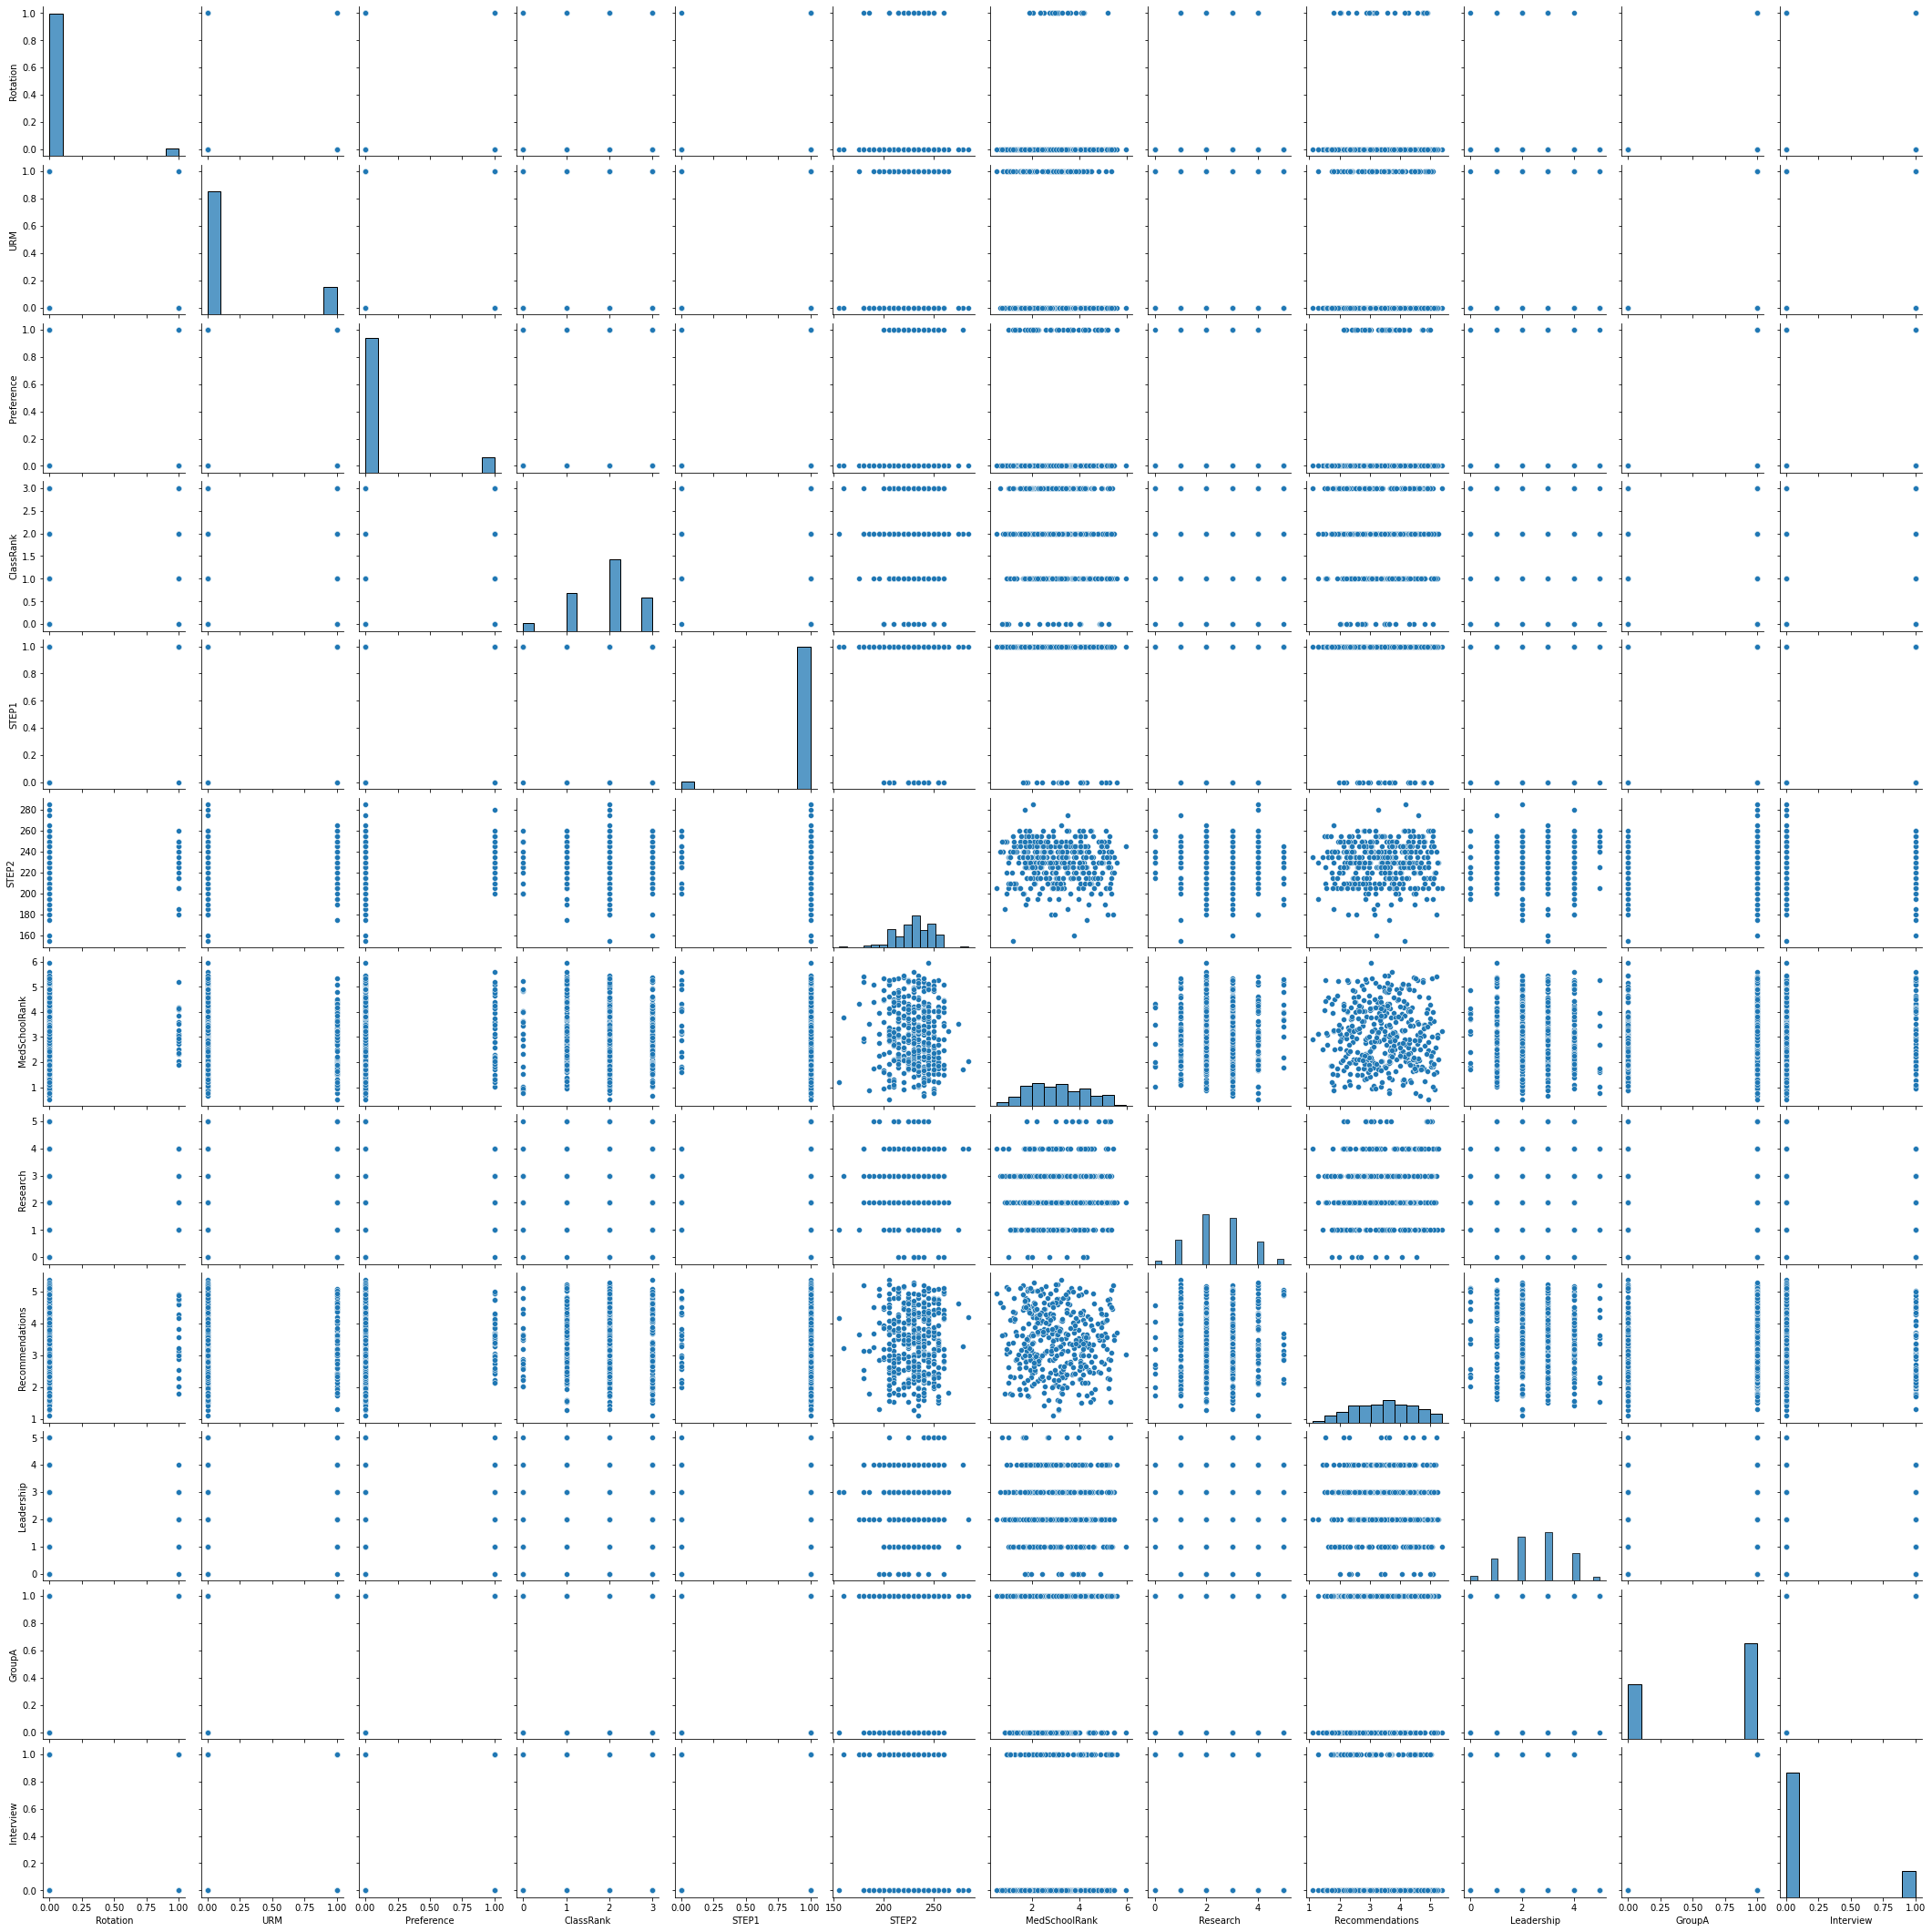

In [7]:
plt.figure()
sns.pairplot(applications)
plt.show()

<Figure size 432x288 with 0 Axes>

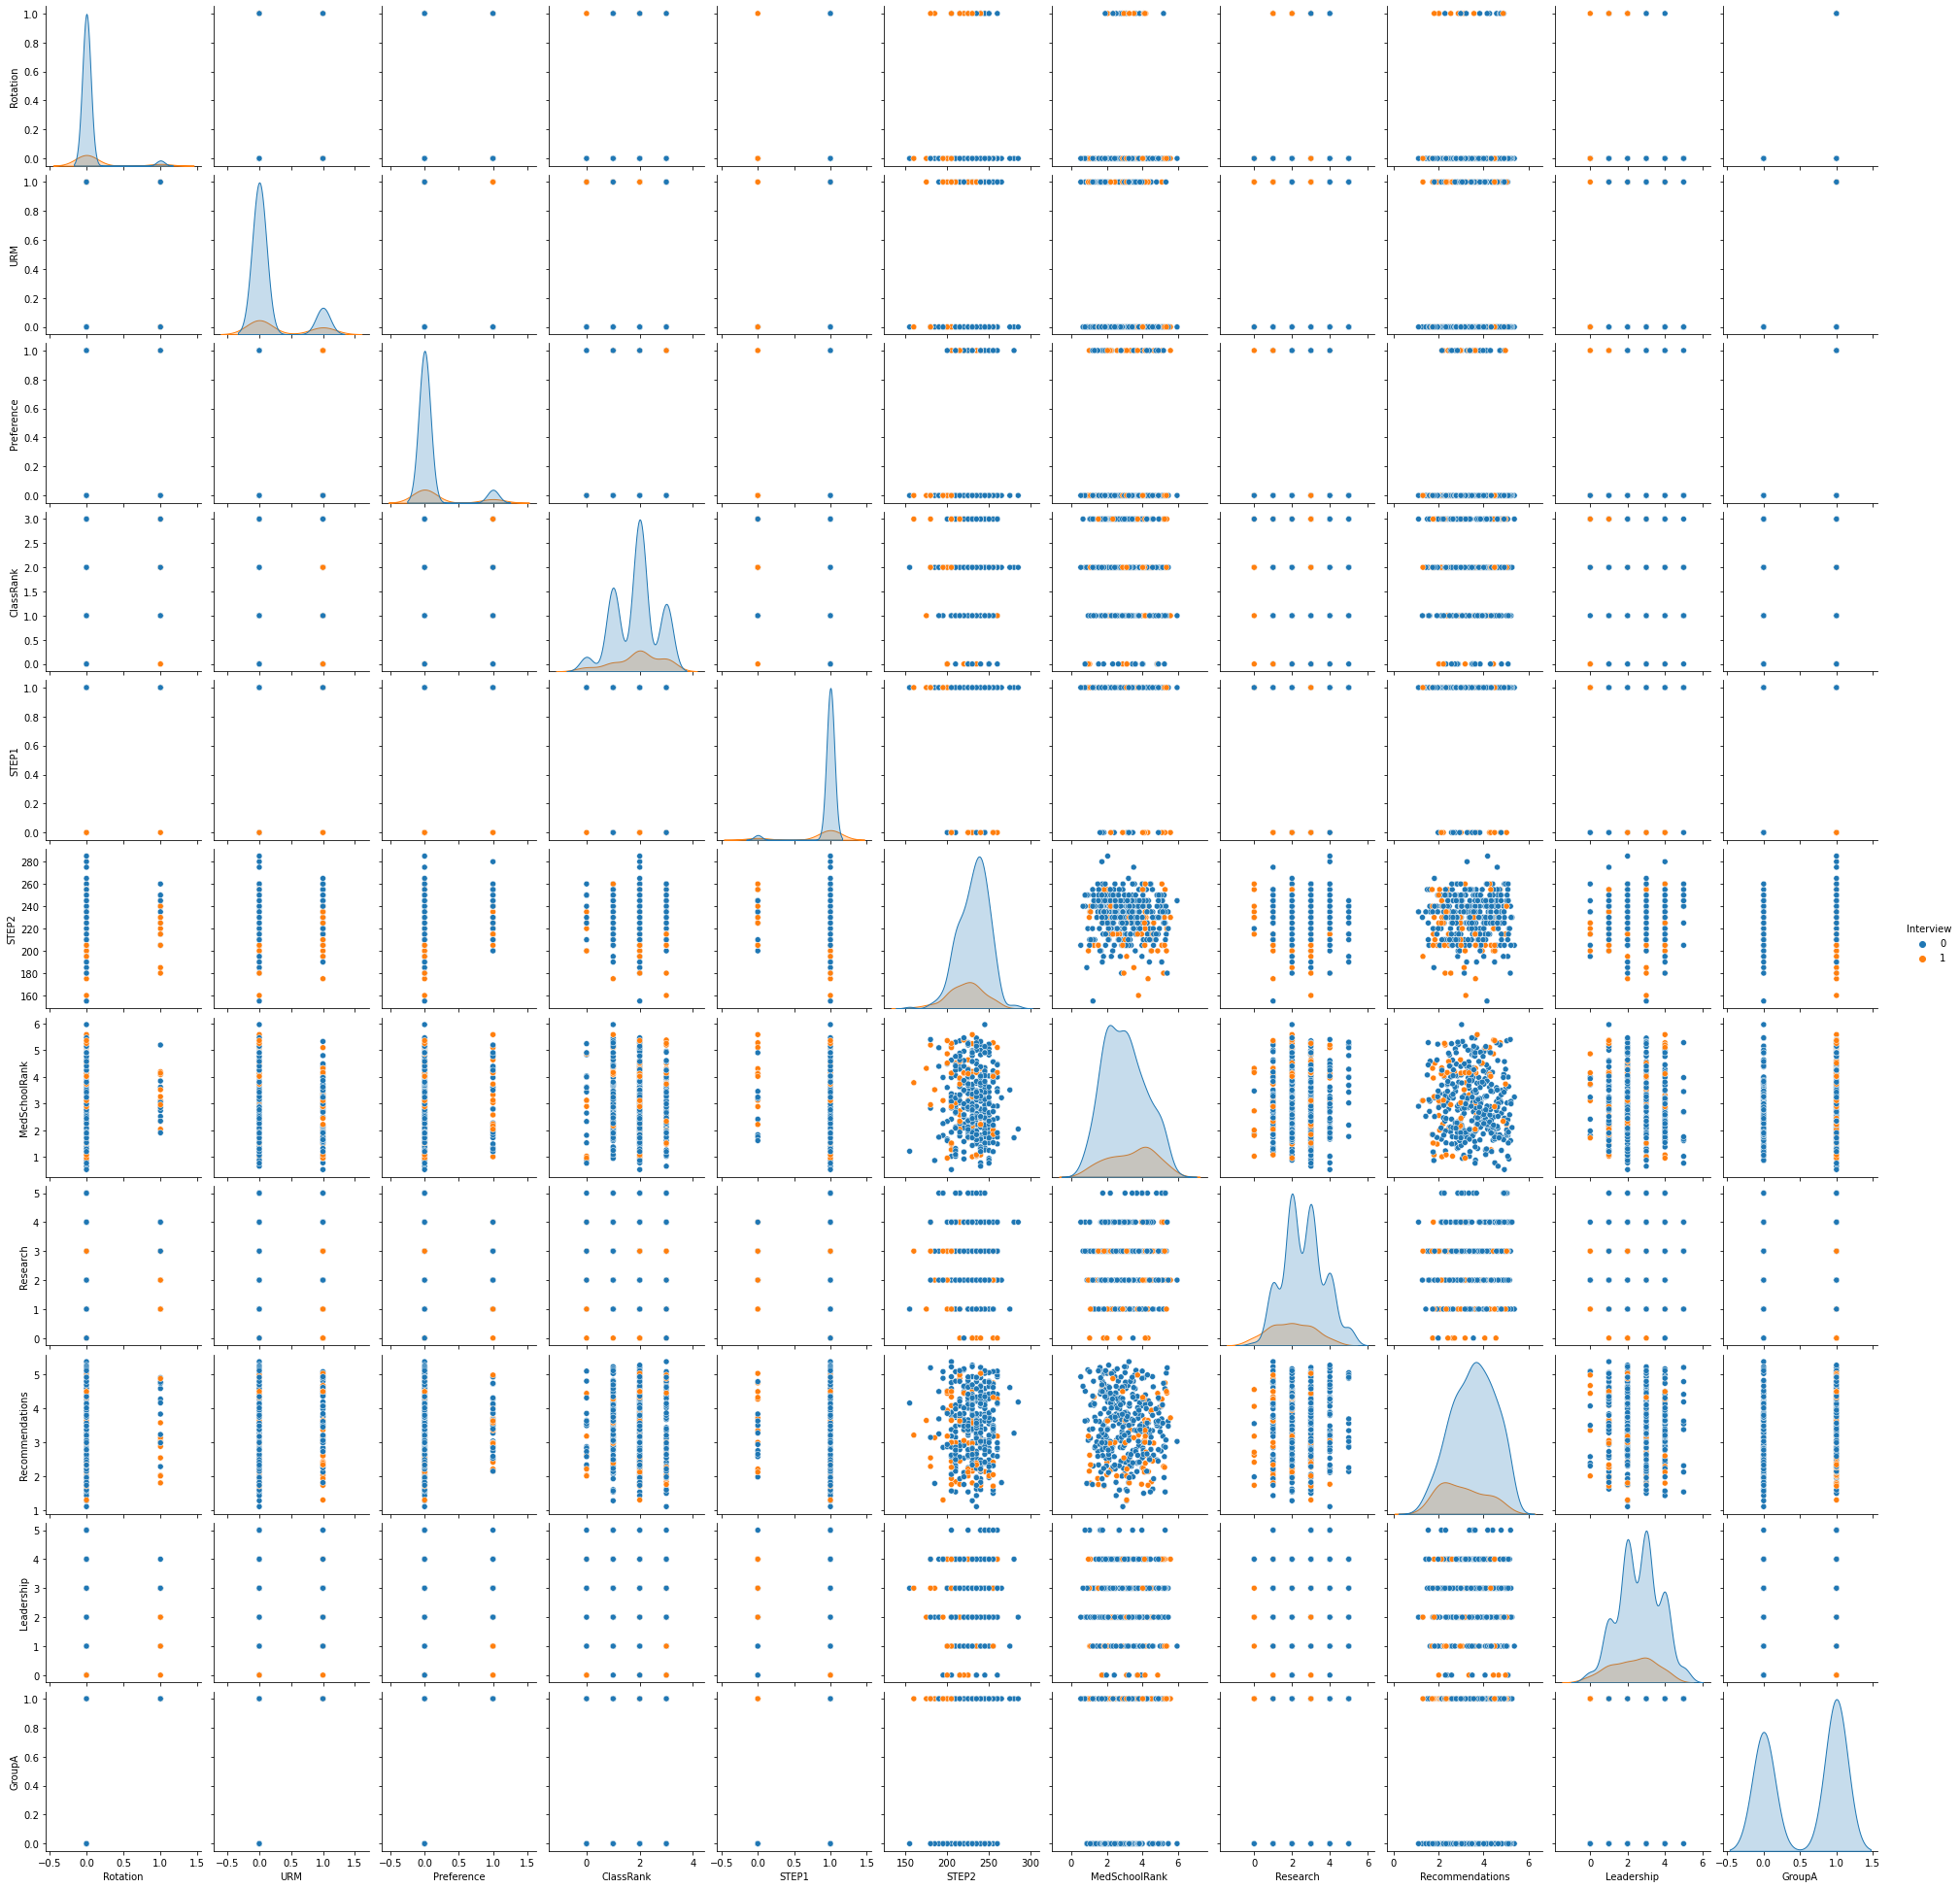

In [8]:
plt.figure()
sns.pairplot(applications, hue='Interview')
plt.savefig('residency_pairplot.pdf')
plt.show()